# Sentiment Analysis of Youtube Comments to Understand Viewer Feedback
## SVM

In [24]:
import numpy as np
import pandas as pd
import re
import nltk
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score


In [2]:
# Define dataset path
file_path = r"C:\Users\12011\OneDrive\Desktop\Social Media Computing\Project\Dataset\Youtube-Spam-Dataset.csv"

# Load the dataset
df = pd.read_csv(file_path, encoding='latin1') 

In [3]:
df

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^...,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .ï»¿,PSY - GANGNAM STYLE(?????) M/V,1
...,...,...,...,...,...,...
1951,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,Shakira - Waka Waka,0
1952,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,Shakira - Waka Waka,0
1953,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,Shakira - Waka Waka,0
1954,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,Shakira - Waka Waka,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


## Data Preprocessing

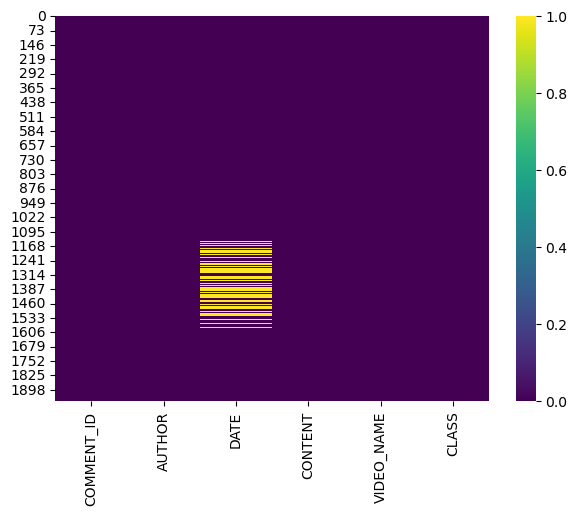

In [5]:
plt.figure(figsize=(7,5))
sns.heatmap(df.isnull(),  cmap='viridis')
plt.show()

In [6]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [7]:
# Display dataset info after cleaning
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1953 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1953 non-null   object
 1   AUTHOR      1953 non-null   object
 2   DATE        1710 non-null   object
 3   CONTENT     1953 non-null   object
 4   VIDEO_NAME  1953 non-null   object
 5   CLASS       1953 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 106.8+ KB
None


## Exploratory Data Analysis (EDA)

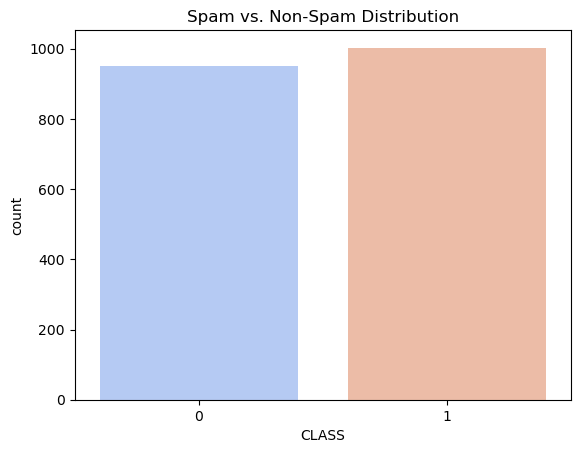

In [8]:
# Countplot for spam vs. non-spam distribution
sns.countplot(x=df['CLASS'], palette="coolwarm")
plt.title("Spam vs. Non-Spam Distribution")
plt.show()

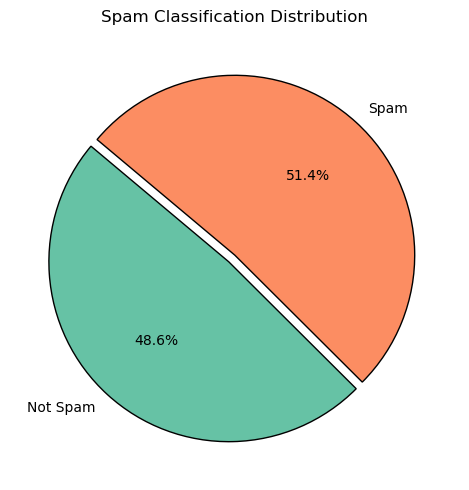

In [9]:
# Count occurrences of each class and sort
class_counts = df['CLASS'].value_counts().sort_index()

# Define color palette
palette = sns.color_palette("Set2", n_colors=len(class_counts))

# Define labels dynamically
labels = class_counts.index.map({0: "Not Spam", 1: "Spam"})  # Adjust mapping as needed

# Create pie chart
fig, ax = plt.subplots(figsize=(7, 5))
ax.pie(class_counts, 
       autopct='%1.1f%%', 
       startangle=140, 
       colors=palette, 
       labels=labels, 
       wedgeprops={'edgecolor': 'black'}, 
       explode=[0.05, 0]  # Slightly separate "Not Spam" slice
      )

# Add title
ax.set_title("Spam Classification Distribution", fontsize=12)

# Display plot
plt.tight_layout()
plt.show()


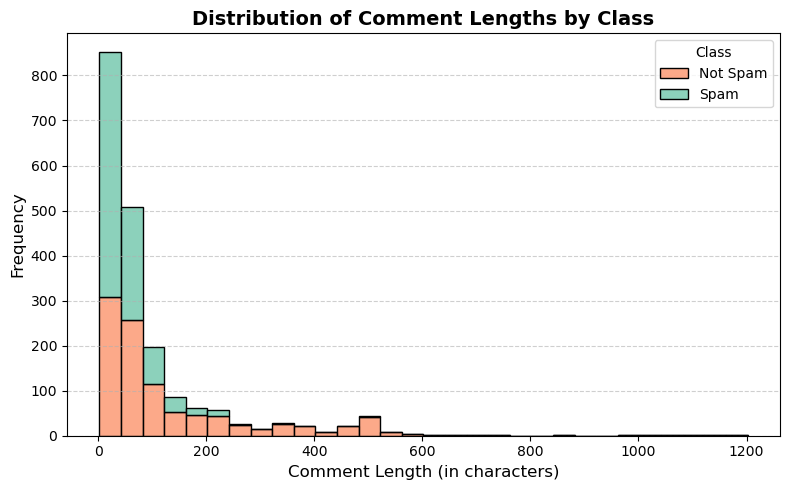

In [10]:
# Create a new column for comment length
df['Comment Length'] = df['CONTENT'].apply(len)

# Define color palette
palette = sns.color_palette("Set2", n_colors=2)

# Create histogram
plt.figure(figsize=(8, 5))
sns.histplot(df, x='Comment Length', hue='CLASS', multiple='stack', 
             palette=palette, bins=30, alpha=0.75, edgecolor="black")

# Add title and labels
plt.title('Distribution of Comment Lengths by Class', fontsize=14, fontweight='bold')
plt.xlabel('Comment Length (in characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Customize legend
plt.legend(title='Class', labels=['Not Spam', 'Spam'])

# Improve layout
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()


## Text Preprocessing

In [11]:
# Download required NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define text cleaning function
def clean_text(text):
    if pd.isna(text): return ""  # Handle NaN values
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

# Apply cleaning to the dataset
df['cleaned_text'] = df['CONTENT'].apply(clean_text)

# Display cleaned text samples
print(df[['CONTENT', 'cleaned_text']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12011\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12011\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12011\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                             CONTENT  \
0  Huh, anyway check out this you[tube] channel: ...   
1  Hey guys check out my new channel and our firs...   
2             just for test I have to say murdev.com   
3  me shaking my sexy ass on my channel enjoy ^_^...   
4          watch?v=vtaRGgvGtWQ   Check this out .ï»¿   

                                        cleaned_text  
0           huh anyway check tube channel kobyoshi02  
1  hey guy check new channel first vid u monkey m...  
2                                test say murdev com  
3                  shaking sexy as channel enjoy _ ï  
4                        watch v vtarggvgtwq check ï  


## Word Cloud for Most Frequent Words

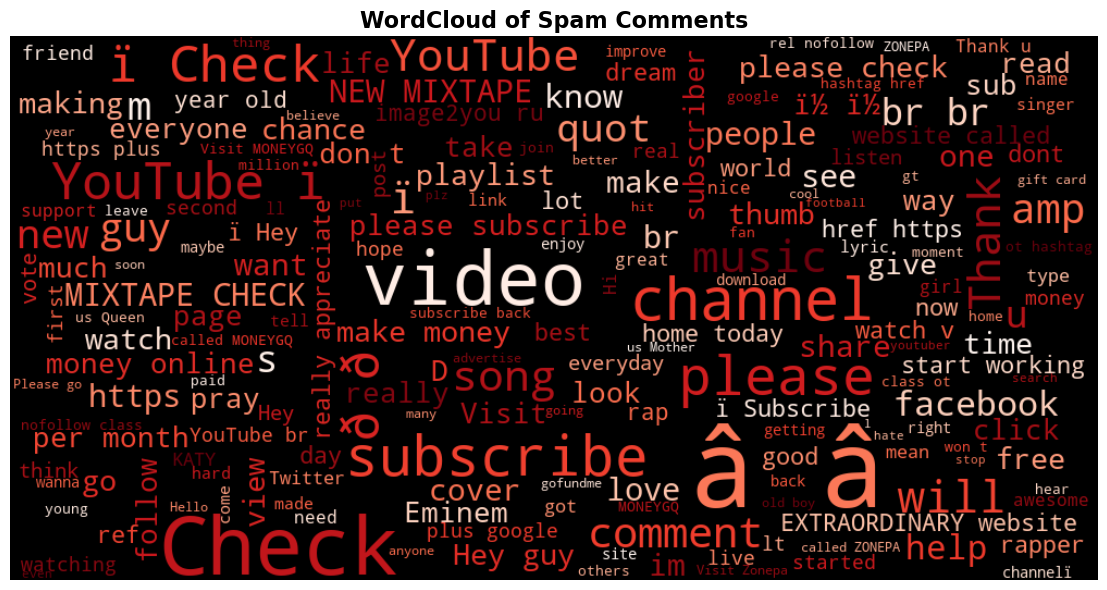

In [12]:
# Concatenate all spam comments into a single string
spam_comments = ' '.join(df[df['CLASS'] == 1]['CONTENT'])

# Define stopwords to improve relevance
stopwords = set(STOPWORDS)

# Generate the WordCloud for spam comments
spam_wordcloud = WordCloud(width=1000, height=500, 
                           background_color='black', 
                           colormap='Reds', 
                           stopwords=stopwords, 
                           max_words=200, 
                           max_font_size=100, 
                           contour_color='white', 
                           contour_width=1).generate(spam_comments)

# Plot the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')

# Remove axes for a clean look
plt.axis('off')
plt.title('WordCloud of Spam Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


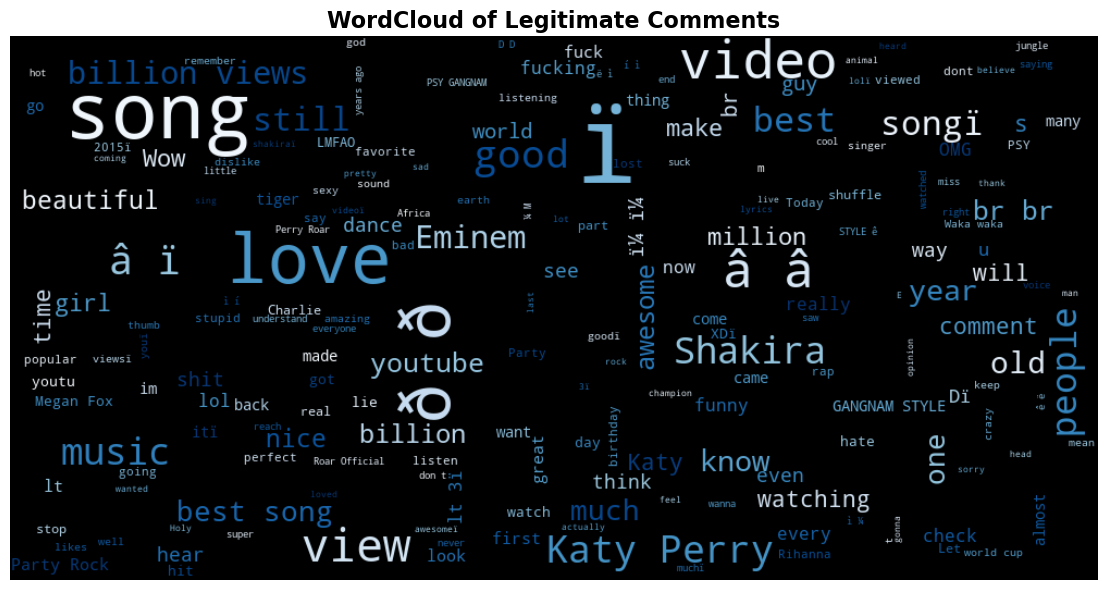

In [13]:
# Concatenate all legitimate comments into a single string
legitimate_comments = ' '.join(df[df['CLASS'] == 0]['CONTENT'])

# Define stopwords to remove common words
stopwords = set(STOPWORDS)

# Generate the WordCloud for legitimate comments
legitimate_wordcloud = WordCloud(width=1000, height=500, 
                                 background_color='black', 
                                 colormap='Blues', 
                                 stopwords=stopwords, 
                                 max_words=200, 
                                 max_font_size=100, 
                                 contour_color='white', 
                                 contour_width=1).generate(legitimate_comments)

# Plot the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(legitimate_wordcloud, interpolation='bilinear')

# Remove axes for a cleaner visualization
plt.axis('off')
plt.title('WordCloud of Legitimate Comments', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

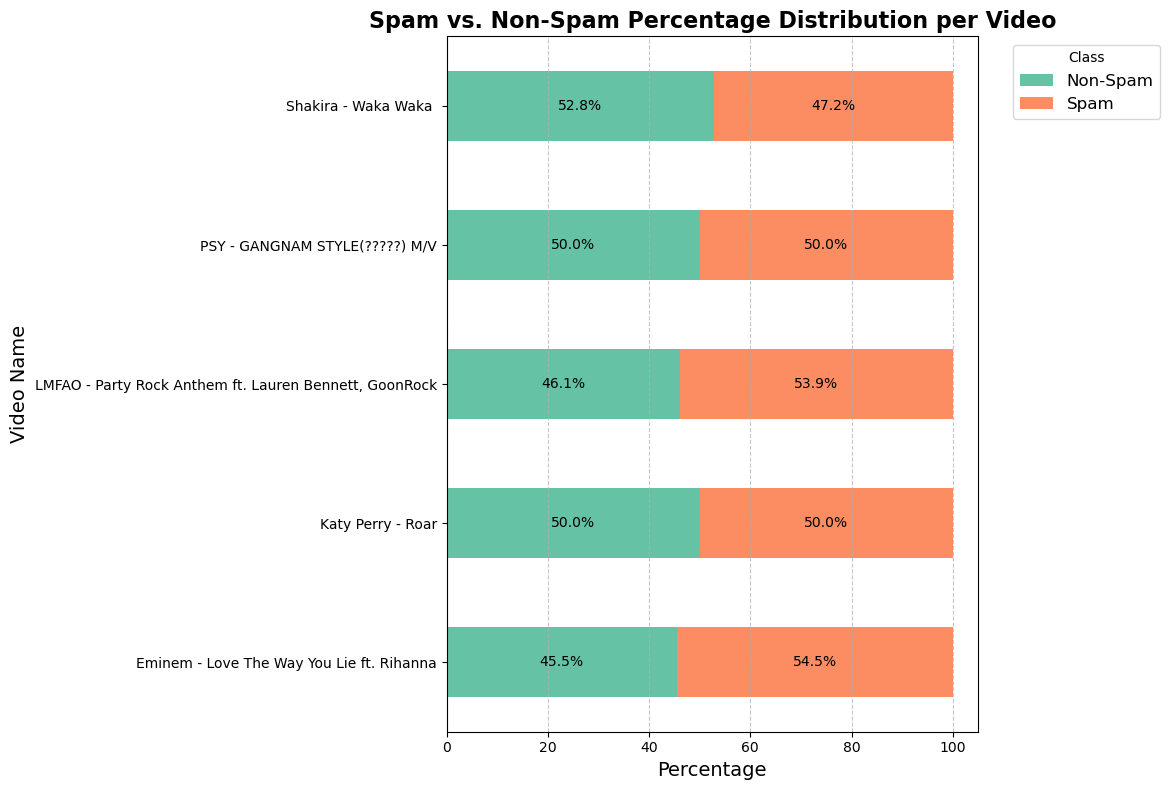

In [14]:
# Group by VIDEO_NAME and CLASS, then calculate percentages
video_class_counts = df.groupby(['VIDEO_NAME', 'CLASS']).size().unstack(fill_value=0)
video_class_percent = video_class_counts.div(video_class_counts.sum(axis=1), axis=0) * 100

# Define a visually appealing color palette
palette = sns.color_palette("Set2", n_colors=2)

# Create the figure and plot
plt.figure(figsize=(12, 8))
ax = video_class_percent.plot(kind='barh', stacked=True, color=palette, ax=plt.gca())

# Add percentage labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10, color='black')

# Improve legend placement and clarity
ax.legend(title='Class', labels=['Non-Spam', 'Spam'], fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Set title and labels
plt.title('Spam vs. Non-Spam Percentage Distribution per Video', fontsize=16, fontweight='bold')
plt.xlabel('Percentage', fontsize=14)
plt.ylabel('Video Name', fontsize=14)

# Adjust y-ticks for readability (rotate if necessary)
plt.yticks(fontsize=10)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


## Convert Text into Numerical Representation

In [15]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize stemmer and lemmatizer
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

# Text preprocessing functions
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def tokenization(text):
    tokens = re.split(r'\W+', text)  # Corrected regex for splitting
    return tokens

def remove_stopwords(tokens):
    stopwords_list = nltk.corpus.stopwords.words('english')
    return [word for word in tokens if word not in stopwords_list]

def stemming(tokens):
    stemmed_text = [porter_stemmer.stem(word) for word in tokens]
    return stemmed_text

# Create an explicit copy of the DataFrame to avoid SettingWithCopyWarning
data = df[['CONTENT', 'CLASS']].copy()

# Apply text preprocessing using .loc to avoid SettingWithCopyWarning
data.loc[:, 'CONTENT'] = data['CONTENT'].apply(lambda x: remove_punctuation(x))
data.loc[:, 'CONTENT'] = data['CONTENT'].apply(lambda x: x.lower())
data.loc[:, 'CONTENT'] = data['CONTENT'].apply(lambda x: tokenization(x))
data.loc[:, 'CONTENT'] = data['CONTENT'].apply(lambda x: remove_stopwords(x))
data.loc[:, 'CONTENT'] = data['CONTENT'].apply(lambda x: stemming(x))

# Join the tokens back into a string for each row
data.loc[:, 'CONTENT'] = data['CONTENT'].apply(lambda x: ' '.join(x))

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = data['CONTENT']
y = data['CLASS']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12011\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12011\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12011\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(X)

## Train-Test Split

Training set distribution:
 1    802
0    760
Name: CLASS, dtype: int64

Testing set distribution:
 1    201
0    190
Name: CLASS, dtype: int64


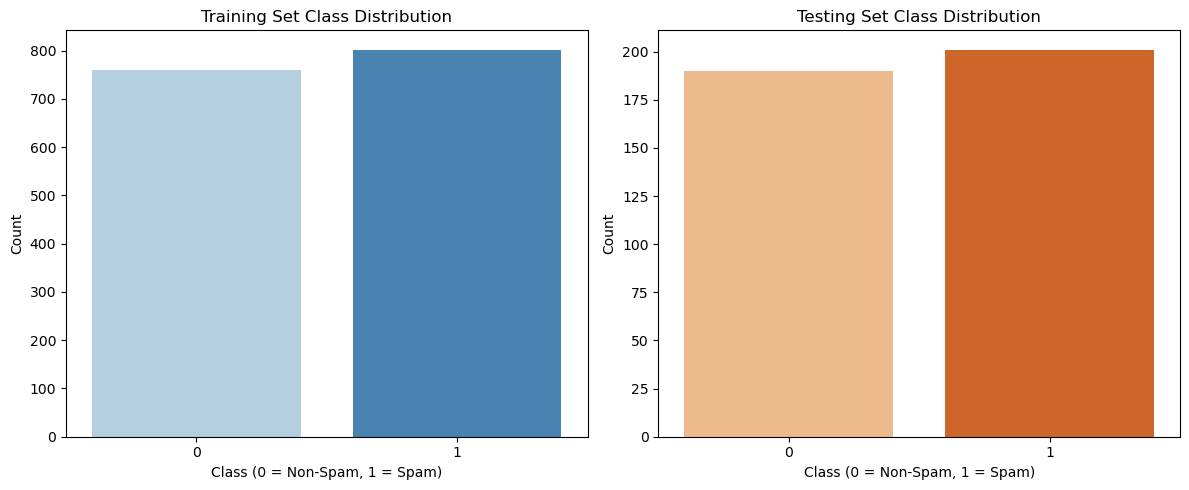

In [17]:
# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display class distributions
print("Training set distribution:\n", y_train.value_counts())
print("\nTesting set distribution:\n", y_test.value_counts())

# Create subplots for training and testing set distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
sns.countplot(x=y_train, ax=ax[0], palette="Blues")
ax[0].set_title("Training Set Class Distribution")
ax[0].set_xlabel("Class (0 = Non-Spam, 1 = Spam)")
ax[0].set_ylabel("Count")

# Testing set distribution
sns.countplot(x=y_test, ax=ax[1], palette="Oranges")
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_xlabel("Class (0 = Non-Spam, 1 = Spam)")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Model Training

In [20]:
# 8. SVM/SVC
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_train_accuracy = accuracy_score(y_train, svm_classifier.predict(X_train))
svm_test_accuracy = accuracy_score(y_test, svm_predictions)

print("\nSVM/SVC Train Accuracy:", svm_train_accuracy)
print("SVM/SVC Test Accuracy:", svm_test_accuracy)


SVM/SVC Train Accuracy: 0.9993597951344431
SVM/SVC Test Accuracy: 0.887468030690537


## Model Evaluation


SVM Train Accuracy: 0.9993597951344431
SVM Test Accuracy: 0.887468030690537
SVM Confusion Matrix:
 [[186   4]
 [ 40 161]]

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89       190
           1       0.98      0.80      0.88       201

    accuracy                           0.89       391
   macro avg       0.90      0.89      0.89       391
weighted avg       0.90      0.89      0.89       391



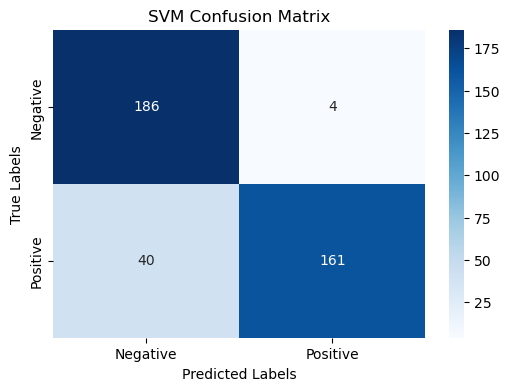

In [22]:
# Compute accuracy
svm_train_accuracy = accuracy_score(y_train, svm_classifier.predict(X_train))
svm_test_accuracy = accuracy_score(y_test, svm_predictions)

print("\nSVM Train Accuracy:", svm_train_accuracy)
print("SVM Test Accuracy:", svm_test_accuracy)

# Generate confusion matrix
svm_cm = confusion_matrix(y_test, svm_predictions)

# Print confusion matrix and classification report
print("SVM Confusion Matrix:\n", svm_cm)
print("\nSVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM Confusion Matrix')
plt.show()

## Sentiment Prediction on New Comments

In [28]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    return text.strip()

# Load full dataset (Ensure this matches y_train size)
full_corpus = [
    "This video is amazing! I love it!",
    "Click here to win $1000 now!!!",
    "Great explanation, very useful content.",
    "Subscribe to my channel for free giveaways!",
    "Spam messages contain promotional links.",
    "Amazing tutorial, helped me a lot!",
    "Congratulations, you have won a free trip!"
] * 223  # Duplicate to match y_train length (assuming 1562 samples)

# Generate y_train labels (assuming 0 = Non-Spam, 1 = Spam)
y_train = [0, 1, 0, 1, 1, 0, 1] * 223  # Ensure length matches full_corpus

# Initialize and fit TF-IDF Vectorizer on full_corpus
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(full_corpus)  # Fit and transform training data

# Check that X_train and y_train sizes match
assert len(y_train) == X_train_tfidf.shape[0], "Mismatch in X_train and y_train sizes!"

# Train Logistic Regression Model
logreg_classifier = SVC(max_iter=1000)
logreg_classifier.fit(X_train_tfidf, y_train)  # Now they have the same size

# Function to predict sentiment
def predict_sentiment(comment):
    cleaned_comment = clean_text(comment)
    vectorized_comment = tfidf.transform([cleaned_comment])  # Ensure it uses the same vectorizer
    sentiment = logreg_classifier.predict(vectorized_comment)[0]
    return "Negative (Spam)" if sentiment == 1 else "Positive (Non-Spam)"

# Example new comments for prediction
new_comments = [
    "This video is amazing! I love it!",
    "Click here to win $1000 now!!!",
    "Great explanation, very useful content.",
    "Subscribe to my channel for free giveaways!"
]

print("\nSentiment Prediction on New Comments:")
for comment in new_comments:
    print(f"Comment: {comment} --> Sentiment: {predict_sentiment(comment)}")


Sentiment Prediction on New Comments:
Comment: This video is amazing! I love it! --> Sentiment: Positive (Non-Spam)
Comment: Click here to win $1000 now!!! --> Sentiment: Negative (Spam)
Comment: Great explanation, very useful content. --> Sentiment: Positive (Non-Spam)
Comment: Subscribe to my channel for free giveaways! --> Sentiment: Negative (Spam)


## Model Evaluation of Predictions

In [29]:
# Model Evaluation
y_pred_lr = svm_classifier.predict(X_train_tfidf)
print("\nLogistic Regression Model Evaluation:")
print(classification_report(y_train, y_pred_lr))
print("Accuracy:", accuracy_score(y_train, y_pred_lr))

ValueError: X has 37 features, but SVC is expecting 4027 features as input.

## Visualization of Predictions

Confusion Matrix:
 [[669   0]
 [  0 892]]


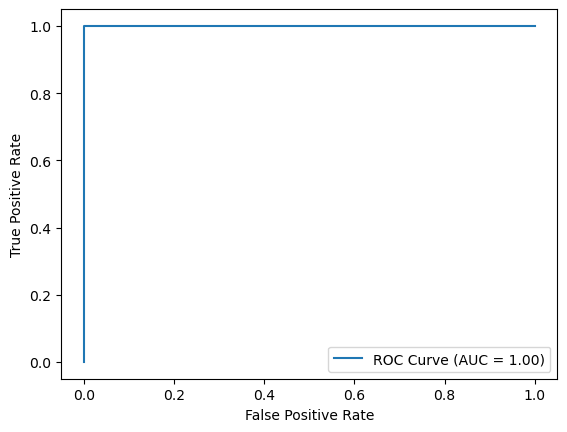

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred_lr)
print("Confusion Matrix:\n", cm)

# ROC Curve
y_prob = logreg_classifier.predict_proba(X_train_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_train, y_prob)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc(fpr, tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()